In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pylite.test import *

In [3]:
loss_func = F.cross_entropy
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()
nfs = [8,16,32,32]
nh,bs = 50,512

In [4]:
x_train,y_train,x_valid,y_valid = get_mnist_data()
x_train,x_valid = normalize_to(x_train,x_valid)

train_ds, valid_ds = get_ds(x_train,y_train,x_valid,y_valid)
data = TabularDataBunch(*get_dls(train_ds, valid_ds, bs))

In [5]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder, partial(AvgStatsCallback,accuracy), partial(BatchTransformXCallback, mnist_view)]

In [6]:
def init_cnn(m, a=0.1, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=a)
            l[0].bias.data.zero_()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [7]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model, a=0.1)
learn = get_learner(model, data, lr=0.9, cbs=cbfs)

train: [0.471375546875, tensor(0.8541)]
valid: [0.141247607421875, tensor(0.9600)]


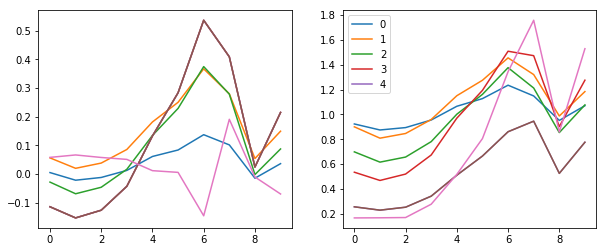

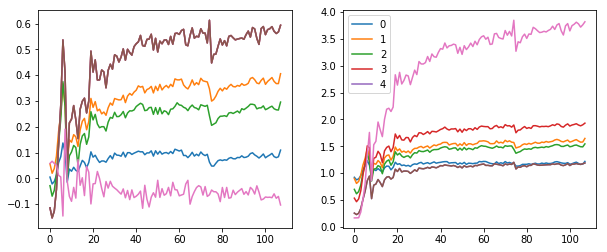

In [8]:
with Hooks(model, append_stats) as hooks:
    learn.fit(1)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5))

In [13]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

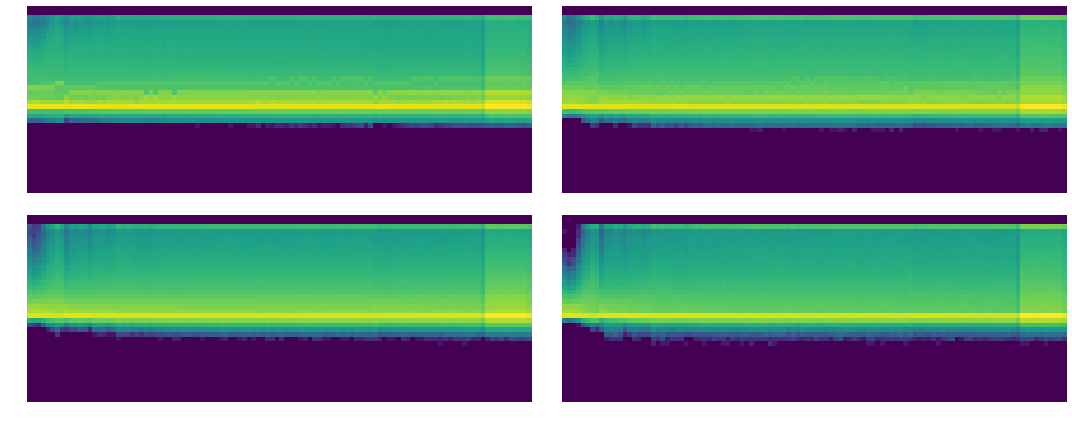

In [10]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [14]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

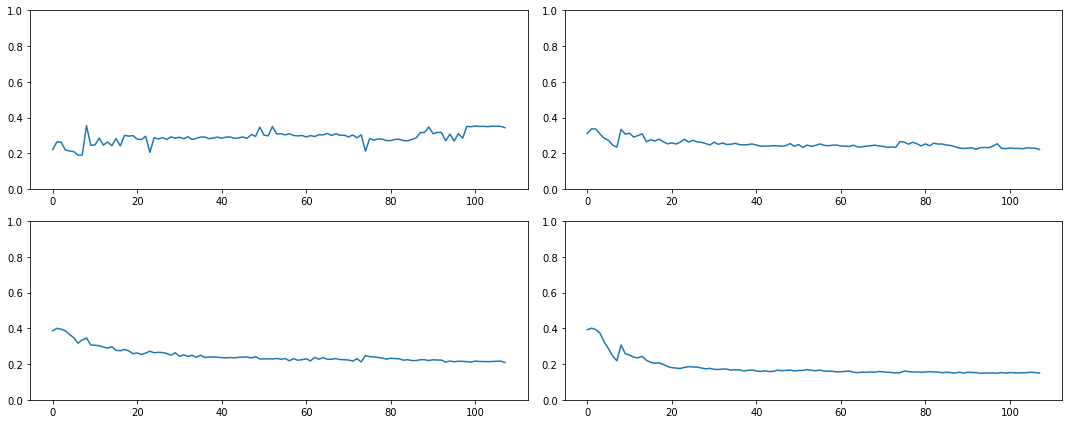

In [12]:
torch.Tensor.ndim = property(lambda x: len(x.shape))
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

# Combine with scheduler

In [17]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [18]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model, a=0.1)
learn = get_learner(model, data, lr=0.9, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

#learn = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

# Cosine training with stats

train: [0.8333534375, tensor(0.7516)]
valid: [0.394829931640625, tensor(0.8735)]
train: [0.29658951171875, tensor(0.9108)]
valid: [1.2896962890625, tensor(0.6330)]
train: [0.1935821875, tensor(0.9406)]
valid: [0.192425537109375, tensor(0.9414)]
train: [0.116789951171875, tensor(0.9638)]
valid: [0.09919554443359375, tensor(0.9709)]
train: [0.0794850048828125, tensor(0.9759)]
valid: [0.08901004028320313, tensor(0.9763)]
train: [0.057379091796875, tensor(0.9824)]
valid: [0.07091563720703126, tensor(0.9794)]
train: [0.045081455078125, tensor(0.9874)]
valid: [0.06643018188476563, tensor(0.9814)]
train: [0.0386248193359375, tensor(0.9897)]
valid: [0.06520571899414063, tensor(0.9817)]


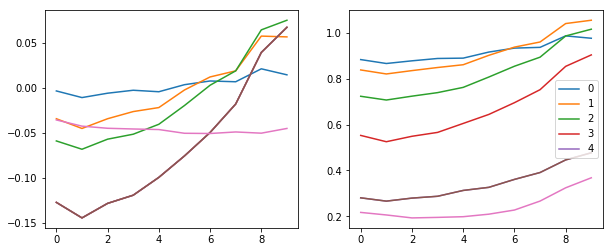

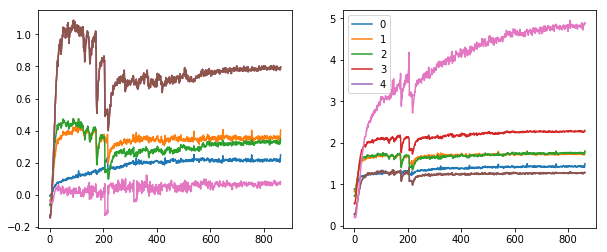

In [19]:
with Hooks(model, append_stats) as hooks:
    learn.fit(8)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5))

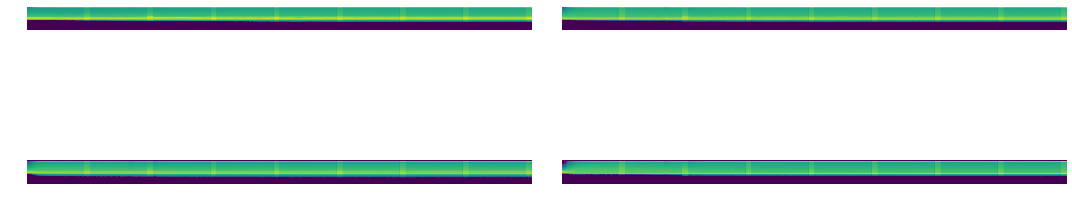

In [20]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

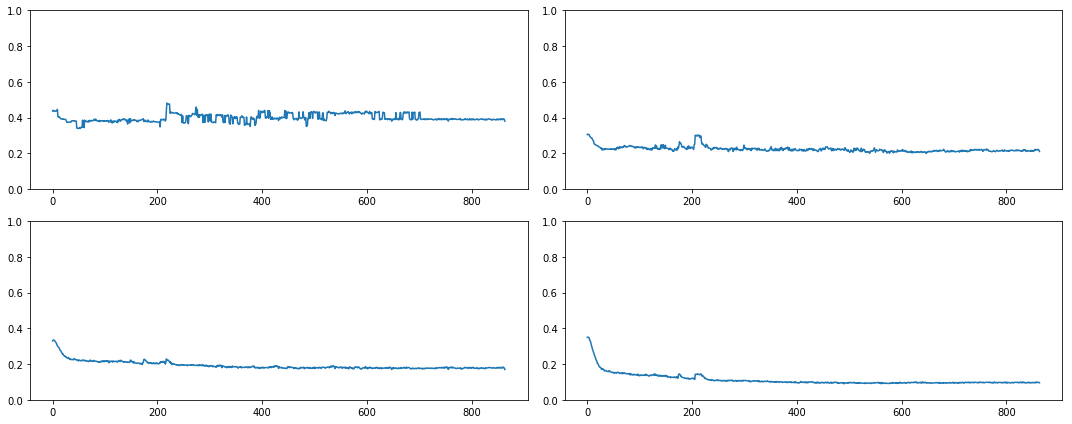

In [21]:
torch.Tensor.ndim = property(lambda x: len(x.shape))
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()